![title](forgeTools/FORGE_gather_strainrate.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eileenrmartin/IntroToDASData/blob/master/forge.ipynb)

---

This notebook aims to teach you how to use wget to download colocated DAS and geophone data from a publically available server, and then process these data with Obspy. In this example, we will look at DAS data from the DOE Enhanced Geothermal System FORGE Project in Utah (USA), and analyze how an earthquake strained an optical fiber deployed in a nearby vertical well for monitoring.
##### Authors:
* [Nate Lindsey](https://www.njlindsey.com)


# Background

### The FORGE Project
The Frontier Observatory for Research in Geothermal Energy (FORGE) project funded by the US Department of Energy and hosted by the University of Utah is creating an underground laboratory for developing and testing innovative tools and stimulation techniques for developing enhanced geothermal system (EGS) reservoirs. The R&D focus is on strengthening understanding of the key mechanisms controlling EGS success, specifically how to initiate and sustain fracture networks in basement rock formations through innovative drilling techniques, reservoir stimulation techniques, well connectivity and flow-testing efforts, and novel continuous geophysical monitoring methodologies.

#####  Learn more about FORGE:
- [Univ. Utah FORGE site](https://utahforge.com/)
- [DOE FORGE site](https://www.energy.gov/eere/forge/forge-home)
- [Phase 2C Report from GDR](https://constantine.seis.utah.edu/datasets.html)

### Public Archive of FORGE (Phase-II) Data
As of July 2020, the FORGE (Phase-II) data are publically available in the archive [here](https://constantine.seis.utah.edu/datasets.html).

This site provides access to the seismic data generated by the FORGE project. The data distribution is made possible by the University of Utah's Center for High Performance Computing (CHPC). Note: Near the FORGE project's completion, the waveform data collected here is planned to be transferred to the Incorporated Research Institutions for Seismology Data Management Center (IRIS DMC). When that time comes, we will announce that this service is deprecated

##### The FORGE data include:
- Continuous Silixa iDAS Carina DAS data for 1280 channels from April - May 2019 [[Link to Download Script]](https://constantine.seis.utah.edu/files/get_all_silixa.sh)
- Continuous Schlumberger three-component geophone data from a 12-station array.

### Setup environment
The Python packages we'll use are:

 - pandas, already available in Colab
 - matplotlib.pyplot, already available in Colab
 - obspy, needs to be installed
 - maybe some others** like scipy.fftpack or numpy?*

To run a bash (command-line) command in a Jupyter notebook on Colab, use an ! before the command. Below is the command to install obspy.

In [25]:
%matplotlib notebook
!pip -q install obspy
import os
import obspy
from forgeTools import utils
import matplotlib.pyplot as plt
import numpy as np

# import pandas as pd
# 
# import scipy.fftpack as ft
# import matplotlib.pyplot as plt

You should consider upgrading via the '/Users/nate/.pyenv/versions/3.7.3/bin/python3.7 -m pip install --upgrade pip' command.


# 0. Check out how easy this will be eventually...

FORGE_78-32_iDASv3-P11_UTC190424221954.sgy alrady downloaded!
FORGE_78-32_iDASv3-P11_UTC190424222009.sgy alrady downloaded!
20190424221950.196.segy alrady downloaded!
20190424222006.196.segy alrady downloaded!
Reading forgeData/FORGE_78-32_iDASv3-P11_UTC190424221954.sgy
Reading forgeData/FORGE_78-32_iDASv3-P11_UTC190424222009.sgy
Reading forgeData/20190424221950.196.segy
Reading forgeData/20190424222006.196.segy


<IPython.core.display.Javascript object>


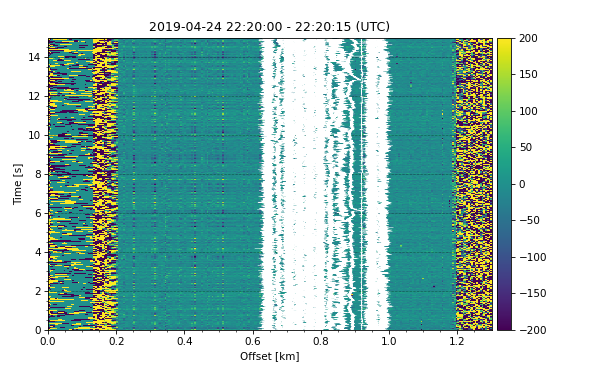

In [6]:
def easy():    

    #setup
    gaugelength     = 10.0
    dx_in_m         = 1.02
    das_units       = 'ne/s'
    geophone_units  = 'm/s^2'
    geophone_fac    = 2.333e-7
    start = obspy.UTCDateTime(2019,4,24,22,20,0) # perforation #1 for demonstration
    end   = obspy.UTCDateTime(2019,4,24,22,20,15)
    
    #download
    files_das = utils.download(utils.get_paths('das',[start,end]))
    files_geo = utils.download(utils.get_paths('geophone',[start,end]))
    
    #read
    das   = utils.read(files_das,dx_in_m=dx_in_m,timerange=[start,end],units=das_units)
    geo   = utils.read(files_geo,timerange=[start,end],fac=geophone_fac,units=geophone_units)
    
    #plot
    fig = utils.image(das,style=1,skip=5,clim=[-200,200])
    fig = utils.wiggle(geo.select(channel='Z'),skip=1,color='w',scale=2.,fig=fig)
    plt.xlim([0,1.3]);
    
#
easy()

# 1. Download FORGE Data

### Some catalogued events

Let's start by looking for a particular time in the continuous dataset when we know there will be some action.

In [8]:
events = {'0':{'eventName':'perf1','eventTime':obspy.UTCDateTime(2019,4,24,22,24,0)},
          '1':{'eventName':'perf2','eventTime':obspy.UTCDateTime(2019,4,29,16,50,0)}}

### Request and download DAS files from FORGE (Phase-II) archive

Set the times of interest for the event or continuous time period

In [23]:
# Event example
start = events['0']['eventTime']
end = events['0']['eventTime']+10

# Continuous example
# start = obspy.UTCDateTime(2019,5,2,0,12,0)
# end = obspy.UTCDateTime(2019,5,2,0,13,5)

print(start,end)

2019-04-24T22:24:00.000000Z 2019-04-24T22:24:10.000000Z


Convert time range to the unique download urls for either 'das' or 'geophone' using the $\textbf{get_paths}$ method.

In [24]:
urls = utils.get_paths('das',[start,end])

Request each file url using wget in batch mode using the $\textbf{download}$ method. The data will be downloaded to a forgeData directory.

In [6]:
files_das = utils.download(urls)

FORGE_78-32_iDASv3-P11_UTC190502001153.sgy alrady downloaded!
FORGE_78-32_iDASv3-P11_UTC190502001208.sgy alrady downloaded!
FORGE_78-32_iDASv3-P11_UTC190502001223.sgy alrady downloaded!
FORGE_78-32_iDASv3-P11_UTC190502001238.sgy alrady downloaded!
FORGE_78-32_iDASv3-P11_UTC190502001253.sgy alrady downloaded!


Now, repeat the above 2 steps but for the geophone data, so we have it for later comparisons. The geophone data will be downloaded to the forgeTools directory also, but we can tell these apart by their filenames (note the different suffix).

In [7]:
urls2 = utils.get_paths('geophone',[start,end])
files_geo = utils.download(urls2)

20190502001149.236.segy alrady downloaded!
20190502001205.236.segy alrady downloaded!
20190502001221.236.segy alrady downloaded!
20190502001237.236.segy alrady downloaded!
20190502001253.236.segy alrady downloaded!


### IMPORTANT: A note on data formats

There are presently many DAS data formats including SEG-Y, Mini-SEED, TDMS, HDF-5, and PRODML. The array datatype, size of individual files, and desire to be able to slice sections of the array in space and time are driving the community to adopt heirarchical dataformats (HDF-5, PRODML). However, the standard is yet to be set (as of July 2020). 

The FORGE Project (Phase-II) recorded SEG-Y data files. SEG-Y files are organized Streams of seismic waveform Traces with individual trace headers describing channel parameters. This is similar to Mini-SEED.

### IMPORTANT: Clarify experiment details including gaugelength, units, and ch spacing

In Silixa's Survey Report (Section 2.2, p.5) described in the Phase 2C Report (B.III), we are told that the DAS data were recorded with a Silixa iDAS IU which used a 10-m gauge length. 

In [10]:
gaugelength = 10.0

In Section 3.4 (p.12), we are also told that the units of the iDAS data are nanostrain/second (nm/m/s). This is not what is natively recorded by the Silixa iDAS (optical phase / timesample), but the scalar conversion has already been applied. The analogy here is how a seismometer records a voltage in V, but the instrument manufacturer may deliver data in m/s having already applied the scalar V/m/s conversion factor.

In [11]:
das_units = 'ne/s'

We are also told that the channel spacing is 1.02 m.

In [12]:
dx_in_m = 1.02

For the geophone data, we are told:
    The following is downhole geophone data collected by Schlumberger. The format is a standard SEGY and the units are bits. To convert to acceleration ($m/s^2$) multiply by $2.333 x 10^{-7}$.

In [13]:
geophone_fac = 2.333e-7
geophone_units = 'm/s^2'

### Read in an example DAS SEG-Y file, check trace header details

Using Obspy, try reading in the first SEG-Y file downloaded above. 

1280 Trace(s) in Stream:

Seq. No. in line:    1 | 2019-05-02T00:11:53.000000Z - 2019-05-02T00:12:07.999500Z | 2000.0 Hz, 30000 samples
...
(1278 other traces)
...
Seq. No. in line: 1280 | 2019-05-02T00:11:53.000000Z - 2019-05-02T00:12:07.999500Z | 2000.0 Hz, 30000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


<IPython.core.display.Javascript object>


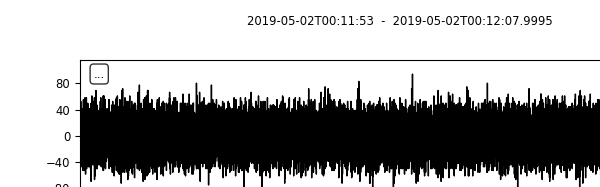

In [17]:
import obspy
das = obspy.read(files_das[0],format='segy') # need to add a format b/c suffix
print(das)
das[300].plot();

Using Obspy, try reading in the first SEG-Y file downloaded above. 

Note: the normal obspy read function will not work, so use obspy.io.segy.core._read_segy() instead and make sure to set the unpack_trace_headers parameter=True.

In [18]:
import obspy.io.segy.core
das = obspy.io.segy.core._read_segy(files_das[0],format='segy',unpack_trace_headers=True)
print(das)

1280 Trace(s) in Stream:

Seq. No. in line:    1 | 2019-05-02T00:11:53.000000Z - 2019-05-02T00:12:07.999500Z | 2000.0 Hz, 30000 samples
...
(1278 other traces)
...
Seq. No. in line: 1280 | 2019-05-02T00:11:53.000000Z - 2019-05-02T00:12:07.999500Z | 2000.0 Hz, 30000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


There are 1280 Traces or "channels" to this DAS recording. The Traces are indexed from 1. The files are natively recorded at 2000 sps, and they are written every 15-s to reduce the indivudial file size (154 MB is still getting pretty big!). 

Examine the first Trace of this 15-s stream.

In [19]:
das[0].stats

         network: 
         station: 
        location: 
         channel: 
       starttime: 2019-05-02T00:11:53.000000Z
         endtime: 2019-05-02T00:12:07.999500Z
   sampling_rate: 2000.0
           delta: 0.0005
            npts: 30000
           calib: 1.0
            segy: AttribDict({'trace_header': AttribDict({'endian': '>', 'unpacked_header': None, 'trace_sequence_number_within_line': 1, 'trace_sequence_number_within_segy_file': 0, 'original_field_record_number': 63014, 'trace_number_within_the_original_field_record': 1, 'energy_source_point_number': 0, 'ensemble_number': 0, 'trace_number_within_the_ensemble': 1, 'trace_identification_code': 0, 'number_of_vertically_summed_traces_yielding_this_trace': 1, 'number_of_horizontally_stacked_traces_yielding_this_trace': 1, 'data_use': 0, 'distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group': 0, 'receiver_group_elevation': 0, 'surface_elevation_at_source': 0, 'source_depth_below_surface': 0, 'datum_elevatio

To populate the trace header parameters, we need to know the channel increment.

In [20]:
das = utils.populate_das_segy_trace_headers(das,dx_in_m=dx_in_m)

Examine the first Trace again, to verify that the channel and location info are correct. Note that these pieces of info are hard-coded for this experiment in the utils.py file. The "station" is the 5-digit Trace index in the Stream, while the "location" is the position along the fiber in meters. The "channel" is a string that could be providing an orientation of the single component in the horizontal direction, or in this case is "Z" for vertical. In order to plot the "section" plot in the next section the "distance" info needs to be populated. 

In [21]:
das[103].stats

         network: FORGE
         station: 00103
        location: 0
         channel: Z
       starttime: 2019-05-02T00:11:53.000000Z
         endtime: 2019-05-02T00:12:07.999500Z
   sampling_rate: 2000.0
           delta: 0.0005
            npts: 30000
           calib: 1.0
        distance: 105.06
            segy: AttribDict({'trace_header': AttribDict({'endian': '>', 'unpacked_header': None, 'trace_sequence_number_within_line': 104, 'trace_sequence_number_within_segy_file': 0, 'original_field_record_number': 63014, 'trace_number_within_the_original_field_record': 104, 'energy_source_point_number': 0, 'ensemble_number': 0, 'trace_number_within_the_ensemble': 104, 'trace_identification_code': 0, 'number_of_vertically_summed_traces_yielding_this_trace': 1, 'number_of_horizontally_stacked_traces_yielding_this_trace': 1, 'data_use': 0, 'distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group': 0, 'receiver_group_elevation': 0, 'surface_elevation_at_source': 0, 'sour

### Read in all the example DAS files and merge

Now that we have downloaded the data and taken a look at how the SEG-Y header info is handeled, go ahead and read in the files with the $\textbf{read}$ method.

If you do not add in the timerange param you will load the full timerange downloaded.
You can also change the timerange at this point to only read in part of the downloaded data.

In [22]:
das = utils.read(files_das,dx_in_m=dx_in_m,timerange=[start,end],units=das_units)

Reading forgeData/FORGE_78-32_iDASv3-P11_UTC190502001153.sgy
Reading forgeData/FORGE_78-32_iDASv3-P11_UTC190502001208.sgy
Reading forgeData/FORGE_78-32_iDASv3-P11_UTC190502001223.sgy
Reading forgeData/FORGE_78-32_iDASv3-P11_UTC190502001238.sgy
Reading forgeData/FORGE_78-32_iDASv3-P11_UTC190502001253.sgy


In [23]:
geo = utils.read(files_geo,timerange=[start,end],fac=geophone_fac,units=geophone_units)

Reading forgeData/20190502001149.236.segy
Reading forgeData/20190502001205.236.segy
Reading forgeData/20190502001221.236.segy
Reading forgeData/20190502001237.236.segy
Reading forgeData/20190502001253.236.segy


In [24]:
das[11].stats.segy.trace_header

AttribDict({'endian': '>', 'unpacked_header': None, 'trace_sequence_number_within_line': 12, 'trace_sequence_number_within_segy_file': 0, 'original_field_record_number': 63014, 'trace_number_within_the_original_field_record': 12, 'energy_source_point_number': 0, 'ensemble_number': 0, 'trace_number_within_the_ensemble': 12, 'trace_identification_code': 0, 'number_of_vertically_summed_traces_yielding_this_trace': 1, 'number_of_horizontally_stacked_traces_yielding_this_trace': 1, 'data_use': 0, 'distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group': 0, 'receiver_group_elevation': 0, 'surface_elevation_at_source': 0, 'source_depth_below_surface': 0, 'datum_elevation_at_receiver_group': 5509482, 'datum_elevation_at_source': 0, 'water_depth_at_source': 0, 'water_depth_at_group': 0, 'scalar_to_be_applied_to_all_elevations_and_depths': -1000, 'scalar_to_be_applied_to_all_coordinates': -10, 'source_coordinate_x': 0, 'source_coordinate_y': 0, 'group_coordinate_x': 0, 'gro

In [25]:
geo[11].stats

         network: FORGE
         station: 00003
        location: 0
         channel: Z
       starttime: 2019-05-02T00:12:00.000000Z
         endtime: 2019-05-02T00:13:05.000000Z
   sampling_rate: 2000.0
           delta: 0.0005
            npts: 130001
           calib: 1.0
        distance: 736.72
      processing: ['ObsPy 1.2.1: trim(endtime=UTCDateTime(2019, 5, 2, 0, 13, 5)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2019, 5, 2, 0, 12))']
            segy: AttribDict({'trace_header': AttribDict({'endian': '>', 'unpacked_header': None, 'trace_sequence_number_within_line': 0, 'trace_sequence_number_within_segy_file': 0, 'original_field_record_number': 0, 'trace_number_within_the_original_field_record': 0, 'energy_source_point_number': 0, 'ensemble_number': 0, 'trace_number_within_the_ensemble': 0, 'trace_identification_code': 3, 'number_of_vertically_summed_traces_yielding_this_trace': 0, 'number_of_horizontally_stacked_traces_yielding_this_trace': 0, 'da

# 2. QA/QC the Data

Here is a simple process containing everything needed to restart from scratch.

In [ ]:
def restart():    

    gaugelength     = 10.0
    dx_in_m         = 1.02
    das_units       = 'ne/s'
    geophone_units  = 'm/s^2'
    geophone_fac    = 2.333e-7

    start = obspy.UTCDateTime(2019,4,24,22,20,0) # perforation #1 for demonstration
    end   = obspy.UTCDateTime(2019,5,24,22,21,0)
    files_das = utils.download(utils.get_paths('das',[start,end]))
    files_geo = utils.download(utils.get_paths('geophone',[start,end]))
    das   = utils.read(files_das,dx_in_m=dx_in_m,timerange=[start,end],units=das_units)
    geo   = utils.read(files_geo,timerange=[start,end],fac=geophone_fac,units=geophone_units)
    
    return das,geo,gaugelength
    
das,geo,gaugelength = restart()

FORGE_78-32_iDASv3-P11_UTC190424221954.sgy alrady downloaded!
FORGE_78-32_iDASv3-P11_UTC190424222009.sgy alrady downloaded!
FORGE_78-32_iDASv3-P11_UTC190424222024.sgy alrady downloaded!
FORGE_78-32_iDASv3-P11_UTC190424222039.sgy alrady downloaded!
FORGE_78-32_iDASv3-P11_UTC190424222054.sgy alrady downloaded!
FORGE_78-32_iDASv3-P11_UTC190424222354.sgy alrady downloaded!
FORGE_78-32_iDASv3-P11_UTC190424222409.sgy alrady downloaded!
FORGE_78-32_iDASv3-P11_UTC190424222424.sgy alrady downloaded!
FORGE_78-32_iDASv3-P11_UTC190424222439.sgy alrady downloaded!
FORGE_78-32_iDASv3-P11_UTC190424222454.sgy alrady downloaded!


Next, we will examine the data to make sure everything looks OK. There are 2 plotting methods in the utils package: $\textbf{wiggle}$ and $\textbf{image}$.

### Plot DAS files as wiggle plot

Wiggle plots are good for displaying relative amplitudes.

In this wiggle method you can play with the following parameters: 
- 'skip' every X ch for speed (=10 by default)
- 'style' plots a simple line (=1 by default) or red/blue plot (=2) 
- 'scale' amplitudes (=1.0 by default) 

In [ ]:
fig = utils.wiggle(das,skip=20)

We can also overlay the geophones and DAS traces

In [ ]:
fig = utils.wiggle(das,skip=30,)
fig = utils.wiggle(geo.select(channel='Z'),skip=1,color='r',fig=fig)
plt.xlim([0,1.3]);

### Plot DAS file as image plot

Image plots are good for displaying move-out information.

In this image method you can play with the following parameters: 
- 'skip' every X ch for speed (=10 by default)
- 'style' modifies the trace normalization, 1 for raw, 2 for trace normalized (=1 by default)
- 'clim' clips the colormap to [min,max] (deactivated =[0] by default) 

In [ ]:
fig = utils.image(das,style=1,skip=30,clim=[-200,200])

Just as in the wiggle case, we can plot geophone wiggle data over an image by sending the fig handle into the wiggle call and then making sure to fix the x-axis limits after.

In [ ]:
fig = utils.image(das,style=1,skip=5,clim=[-200,200])
fig = utils.wiggle(geo.select(channel='Z'),skip=1,color='w',scale=2.,fig=fig)
plt.xlim([0,1.3]);

### Read the catalog

# 3. Establish DAS geometry

### Tap Testing

The most common method to establish the geometry of a DAS array is with a field procedure called a 'tap test', in which an impact source (e.g., hammer) is used with GPS measurements at key points on a fiber map. Tap testing maps the DAS channels (linear fiber length) into position in real coordinates. In vertical arrays it is common to use the wellhead as a key point. In horizontal arrays it is common to use corners as key points. In telecommunications arrays, tap testing is more challenging because of inprecise or out-of-date fiber mapping, large burial depth, and poor coupling in conduits and maintenance holes.

### Important: A note on the start and end of the fiber 

The "0" cable poisition might be thought of as beginning at the instrument/cable connection point, however there can be additional fiber inside of the instrument. It is therefore a good practice to "tap test" the instrument/cable connection point. Additionally, because DAS channels are actually converted from a time sampling, it is possible that the array recording extends beyond the physical cable's end. Channels before and after the physical cable length should be masked in preprocessing. It is also a good practice to only trust linear fiber lengths between key points.

### FORGE geometry

In Silixa's Survey Report (Figure 3, p.9), a tap test is described and the following fiber map is delivered:
![Fiber Map](forgeTools/fiberMapping.png)

with a description of the following geometry:
![title](forgeTools/fiberMappingLocations.png)


Note the linear fiber length between the two key points is 1037.8 m - 41.29m = 996.51 m, which is equal to 996.51 m/1.02m/channel = 977 channels. 



In [ ]:
# distances
fo_start_in_m = 196 # need to move this to the wellhead position
fo_end_in_m = fo_start_in_m + 996.51 

# dx
dx_in_m = das[1].stats.distance - das[0].stats.distance

# channels
fo_start_in_ch = int(fo_start_in_m/dx_in_m)
fo_end_in_ch = int(fo_end_in_m/dx_in_m)

### Plot frequency content for a file

Plotting the unfiltered frequency content of some raw data is a good way to begin to understand the DAS geometry.

In [81]:
def plotSpectra(stream,style='image',kind='psd',cmap='magma',clim=[-70,10],trace=999):

    import matplotlib.pyplot as plt
    import numpy as np

    if style=='image':

        A = utils.stream2array(stream)*0
        nx,nt = np.shape(A)
        nyq = nt//2
        dt = stream[0].stats.delta
        A = A[:,slice(1,nyq)]

        for i,tr in enumerate(stream.copy()):
            fr = np.fft.fftfreq(nt,d=dt)[slice(1,nyq)]
            A[i,:] = np.fft.fft(tr.data)[slice(1,nyq)]

        if kind=='as':
            sp = np.abs(A.T)
            sp = 10*np.log10(sp)
            units = 'Amplitude Spectrum [dB] (rel. 1 '+ stream[0].stats.units +')'

        if kind=='ps':
            sp = 2*(np.abs(A.T)**2) / (nt**2)
            sp = 10*np.log10(sp)
            units = 'Power Spectrum [dB rel. 1 ('+stream[0].stats.units+')$^2$)'

        if kind=='psd':
            sp = 2*(np.abs(A.T)**2) / (nt**2) * dt * nt
            sp = 10*np.log10(sp)
            units = 'Power Spectral Density [dB] (rel. 1 ('+stream[0].stats.units+')$^2$/Hz)'

        fig = plt.figure(figsize=(8,5))
        extent=[stream[0].stats.distance/1e3,stream[-1].stats.distance/1e3,min(fr),max(fr)]
        plt.imshow(sp,extent=extent,aspect='auto',origin='lower left',cmap=cmap,vmin=clim[0],vmax=clim[1])
        h=plt.colorbar(label=units,pad=0.01)
        plt.yscale('log')
        plt.title(str(stream[0].stats.starttime.datetime)+' - '+str(stream[0].stats.endtime.datetime.strftime('%H:%M:%S'))+' (UTC)')
        plt.xlabel('Offset [km]')
        plt.ylabel('Frequency [Hz]')
        plt.tight_layout()

    if style=='line':

        nt = len(stream[trace].data)
        nyq = nt//2
        dt = stream[trace].stats.delta

        fr = np.fft.fftfreq(nt,d=dt)[slice(1,nyq)]
        A = np.fft.fft(stream[trace].data)[slice(1,nyq)]

        if kind=='as':
            sp = np.abs(A)
            sp = 10*np.log10(sp)
            units = 'Amplitude Spectrum [dB] (rel. 1 '+ stream[trace].stats.units +')'

        if kind=='ps':
            sp = 2*(np.abs(A)**2) / (nt**2)
            sp = 20*np.log10(sp)
            units = 'Power Spectrum [dB rel. 1 ('+stream[trace].stats.units+')$^2$)'

        if kind=='psd':
            sp = 2*(np.abs(A)**2) / (nt**2) * dt * nt
            sp = 20*np.log10(sp)
            units = 'Power Spectral Density [dB] (rel. 1 ('+stream[trace].stats.units+')$^2$/Hz)'

        fig = plt.figure(figsize=(6,5))
        plt.plot(fr,sp,label=stream[trace].stats.distance)
        plt.xscale('log')
        plt.title(str(stream[trace].stats.starttime.datetime)+' - '+str(stream[trace].stats.endtime.datetime.strftime('%H:%M:%S'))+' (UTC)')
        plt.ylabel(units)
        plt.xlabel('Frequency [Hz]')
        plt.legend()
        plt.tight_layout()

    return fig

<IPython.core.display.Javascript object>


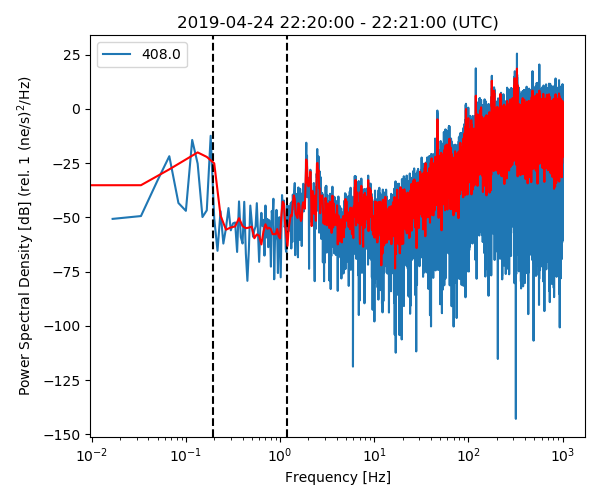

In [82]:
fig = plotSpectra(das,style='line',kind='psd',trace=400)
[plt.axvline(X/1e3,color='k',linestyle='--') for X in [fo_start_in_m,fo_end_in_m]];

from scipy.signal import welch

f,Pxx = welch(das[400].data, fs=das[400].stats.sampling_rate, 
              window='hann', nperseg=30/das[400].stats.delta, 
              noverlap = 30/das[400].stats.delta*.9,
              average='mean') 
plt.semilogx(f,20*np.log10(Pxx),'r')

### Apply a mask to non-well channels

In [14]:
das_ = utils.mask(das,0,fo_start_in_ch)
das_ = utils.mask(das_,fo_end_in_ch,len(das))
fig = utils.plotSpectra(das_[::10],style='image',kind='psd')
[plt.axvline(X/1e3,color='k',linestyle='--') for X in [fo_start_in_m,fo_end_in_m]];

# 4. Measure the DAS Noise Level

### Plot the Noise Power over frequency (note: load an hour of data)

<IPython.core.display.Javascript object>


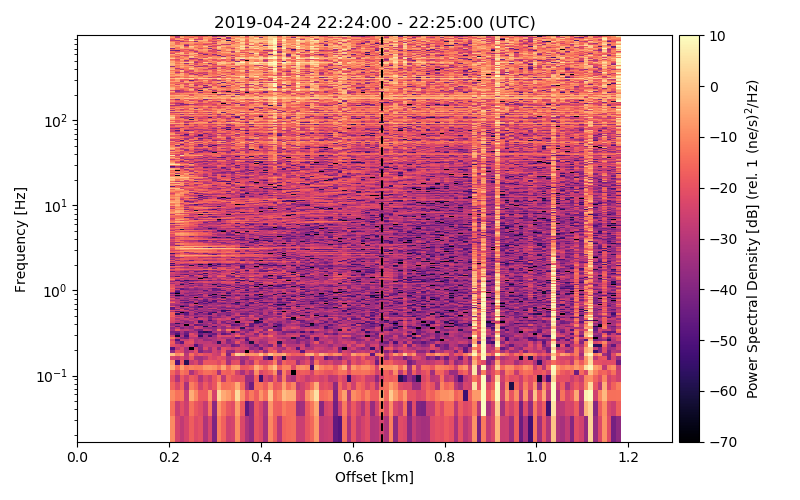

<IPython.core.display.Javascript object>


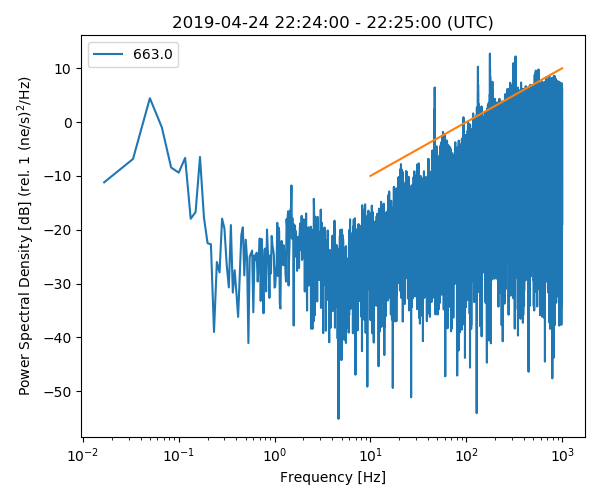

In [44]:
#Choose a trace to focus on
tr = 650

#Plot the image for the full array
fig = plotSpectra(das_[::10],kind='psd')
plt.axvline(das_[tr].stats.distance/1e3,color='k',linestyle='--');

#Plot the line for the trace
fig = plotSpectra(das_,style='line',kind='psd',trace=tr)

#Observe the blue n rise in noise level
plt.plot(np.logspace(1,3,1000),10*np.log10(np.logspace(1,3,1000))-20)

### Plot the raw Noise Power (dB) vs. channel

Silixa method to measure Noise Power in real units

<IPython.core.display.Javascript object>


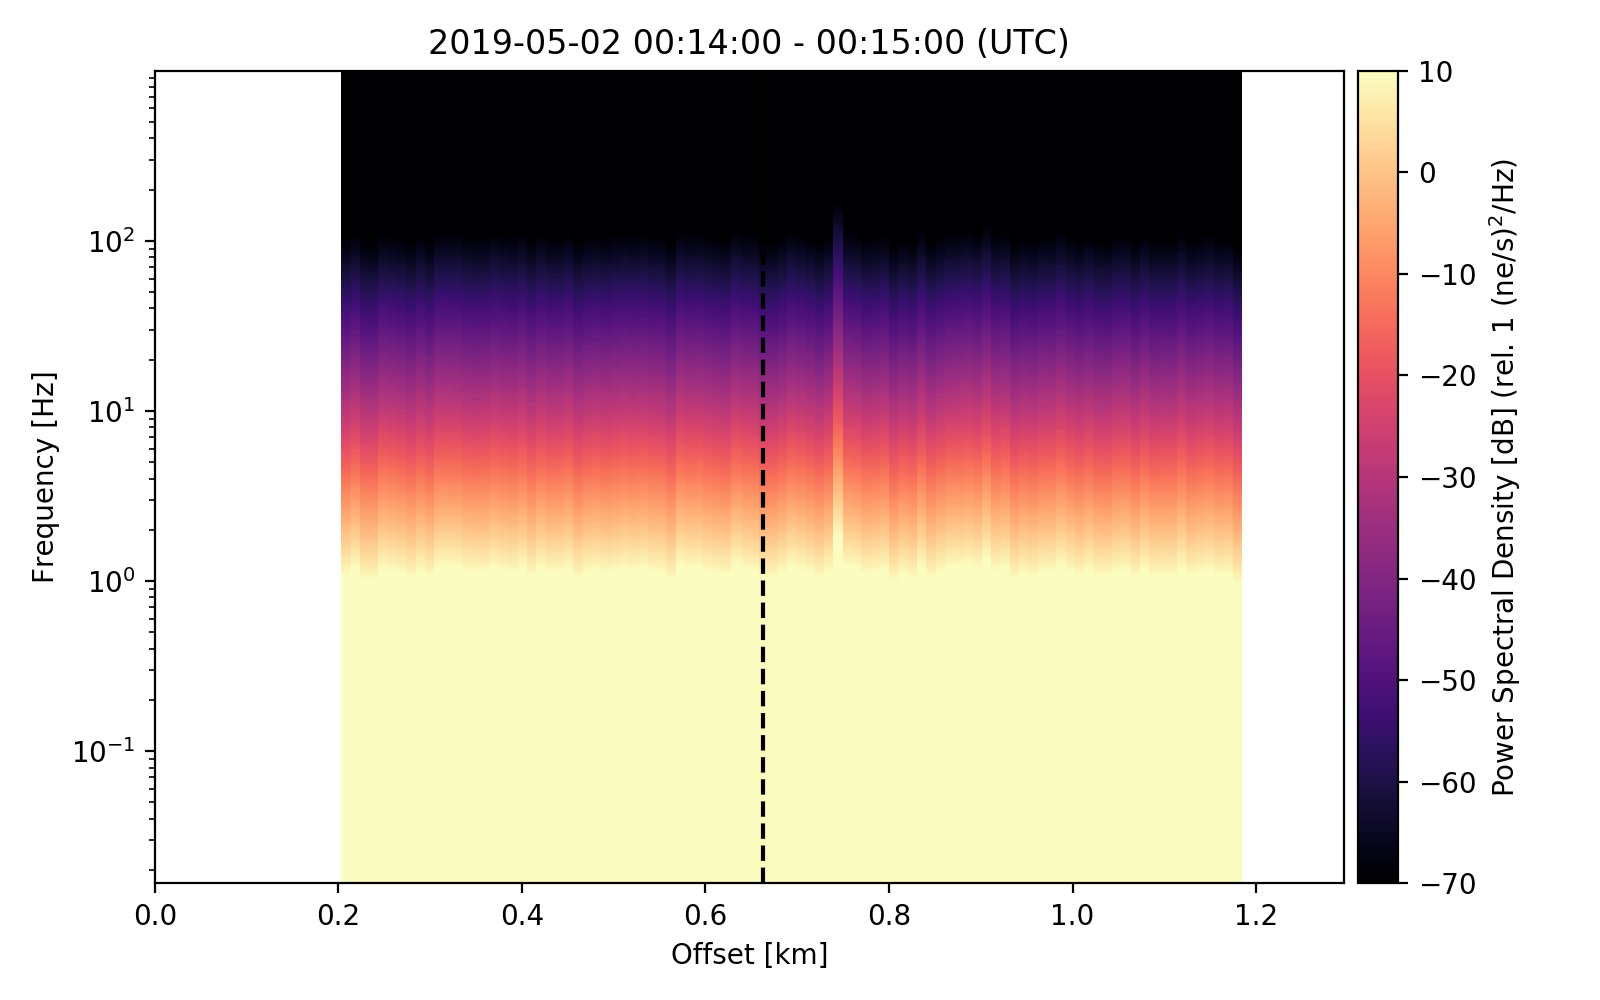

<IPython.core.display.Javascript object>


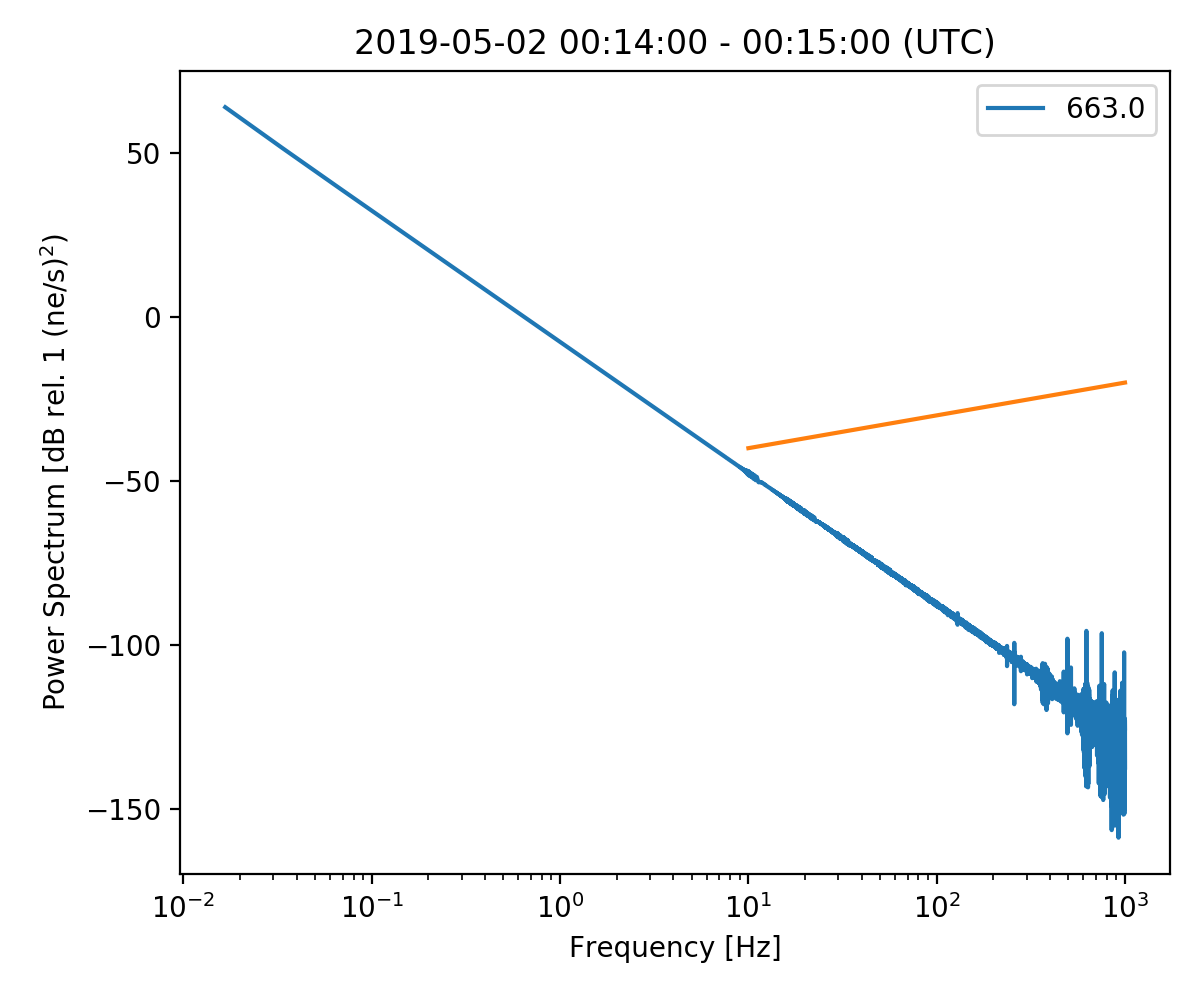

In [205]:
tr = 650

fig = plotSpectra(das_[::10].copy().integrate().detrend(),kind='psd')
plt.axvline(das_[tr].stats.distance/1e3,color='k',linestyle='--');
fig = plotSpectra(das_.copy().integrate().detrend(),style='line',kind='ps',trace=tr)
plt.plot(np.logspace(1,3,1000),10*np.log10(np.logspace(1,3,1000))-50)

### Mask faded channels

In [ ]:
Destructive interference during optical interferometry causes some channels to fade

### Remove mechanical common mode noise, and remeasure the Noise Power

In [ ]:
Common mode noise is an effect of optical interferometry and overprinted on all channels

# 5. Study an Earthquake 

### Plot DAS records for earthquake and visually interpret

### Compare DAS records with geophone records

In [6]:
time = obspy.UTCDateTime("2019-04-27T20:20:57.0") # this is a small microseismic event located by SLB

# Geophone-DAS Analysis

Colocated simultaneous recordings made by inertial geophones and DAS can be compared directly after basic processing. 

The processing steps required for this instrument comparison involve spatial or temporal derivatives. Geophones record the particle velocity due to a propagating displacement wavefield, $U(x,t) = Ae^{i(\omega t-kx)}$, which mathematically is equivalent to taking one time-derivative of the displacement:

$$
\frac{dU(x,t)}{dt} = i\omega Ae^{i(\omega t\pm kx)}
$$

The DAS instrument records the strain-rate field, equivalent to taking one space-derivative and one time-derivative of the displacement:

$$
\frac{d\epsilon(x,t)}{dt} = \frac{d}{dt}(\frac{dU(x,t)}{dx}) = -\omega k Ae^{i(\omega t\pm kx)}.
$$

The amplitude and phase of geophone and DAS data can thus be compared in absolute units of strain by multiplying the geophone data by the inverse phase velocity ($\frac{1}{c}$, a multiplicative constant under the acoustic plane wave assumption) and integrating the DAS data:
$$
\epsilon(x,t) = \frac{\omega}{k}\frac{dU(x,t)}{dt} = \frac{1}{c}\frac{dU(x,t)}{dt}.
$$

Alternatively, we can differentiate the geophone data to acceleration and multiply the DAS data by inverse phase velocity:
$$
\frac{d^2U(x,t)}{dt^2} = -\omega^2 Ae^{i(\omega t\pm kx)}
$$
$$
\frac{d\epsilon(x,t)}{dt} = \frac{\omega}{k}\frac{d}{dt}(\frac{d^2U(x,t)}{dt^2}) = \frac{1}{c}\frac{d^2U(x,t)}{dt^2}
$$

If the phase velocity is unknown, any comparison will only result in a relative amplitude scale (but records should be in-phase).

We process the geophone point sensor data by loading the raw velocity data, applying a linear detrend, mean removal, and 2% taper, then differentiating to acceleration data, and finally applying a two-corner, causal bandpass filter in the range 1 - 1000 Hz. 

We process the DAS array data by applying a linear detrend, mean removal, and 2% taper, then removing the zero-wavenumber noise in the frequency-wavenumber domain over the full array of sensors installed in the well, and finally applying a two-corner, causal bandpass filter in the range 1 - 1000 Hz. 



##### Plot raw gathers

In [101]:
def stream2array(stream):
    import numpy as np
    import obspy
    array=np.empty((len(stream),len(stream[0].data)),dtype=float) # initialize array
    for index,trace in enumerate(stream):
        array[index,:]=trace.data
    return array

def stackLinear(stream):
    import numpy as np
    tr = stream[0].copy()
    arr = stream2array(stream)
    arrData = np.sum(arr,0) / len(stream)
    tr.data = arrData
    return tr

In [102]:
def plotGather(stream,padBefore,padAfter,vmin=-1,vmax=1,trnorm=1):
    import matplotlib.pyplot as plt
    distanceVector = [tr.stats.distance for tr in stream]
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    dt = stream[0].stats.delta
    nt = stream[0].stats.npts
    if trnorm==True:
        arr = stream2array(stream.normalize(global_max=False))
    else:
        arr = stream2array(stream.normalize(global_max=True))
    plt.imshow(arr,aspect='auto',
               extent=[-padBefore,padAfter,max(distanceVector),min(distanceVector)],
               cmap='viridis',vmin=vmin,vmax=vmax)
    h=plt.colorbar(pad=0.01)
    h.set_label('Normalized Strain-rate',rotation=270,labelpad=20)
    plt.ylabel('Linear Fiber Length [m]')
    plt.xlabel('Time [s]')
    return fig,ax

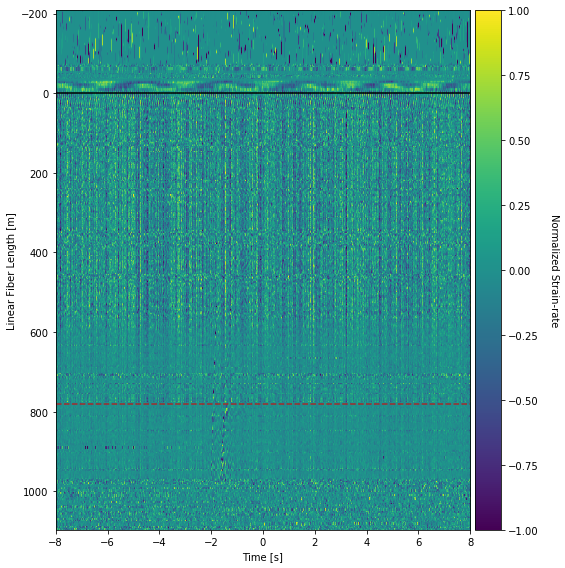

In [112]:
# plot DAS
fig,ax = plotGather(strainrate_from_das,8,8,trnorm=1)
plt.axhline(0,color='k',linestyle='-')
plt.axhline(780,color='brown',linestyle='--')
# plt.xlim([-1.5,-.5])
plt.tight_layout()

##### Plot preprocessed gathers

<IPython.core.display.Javascript object>


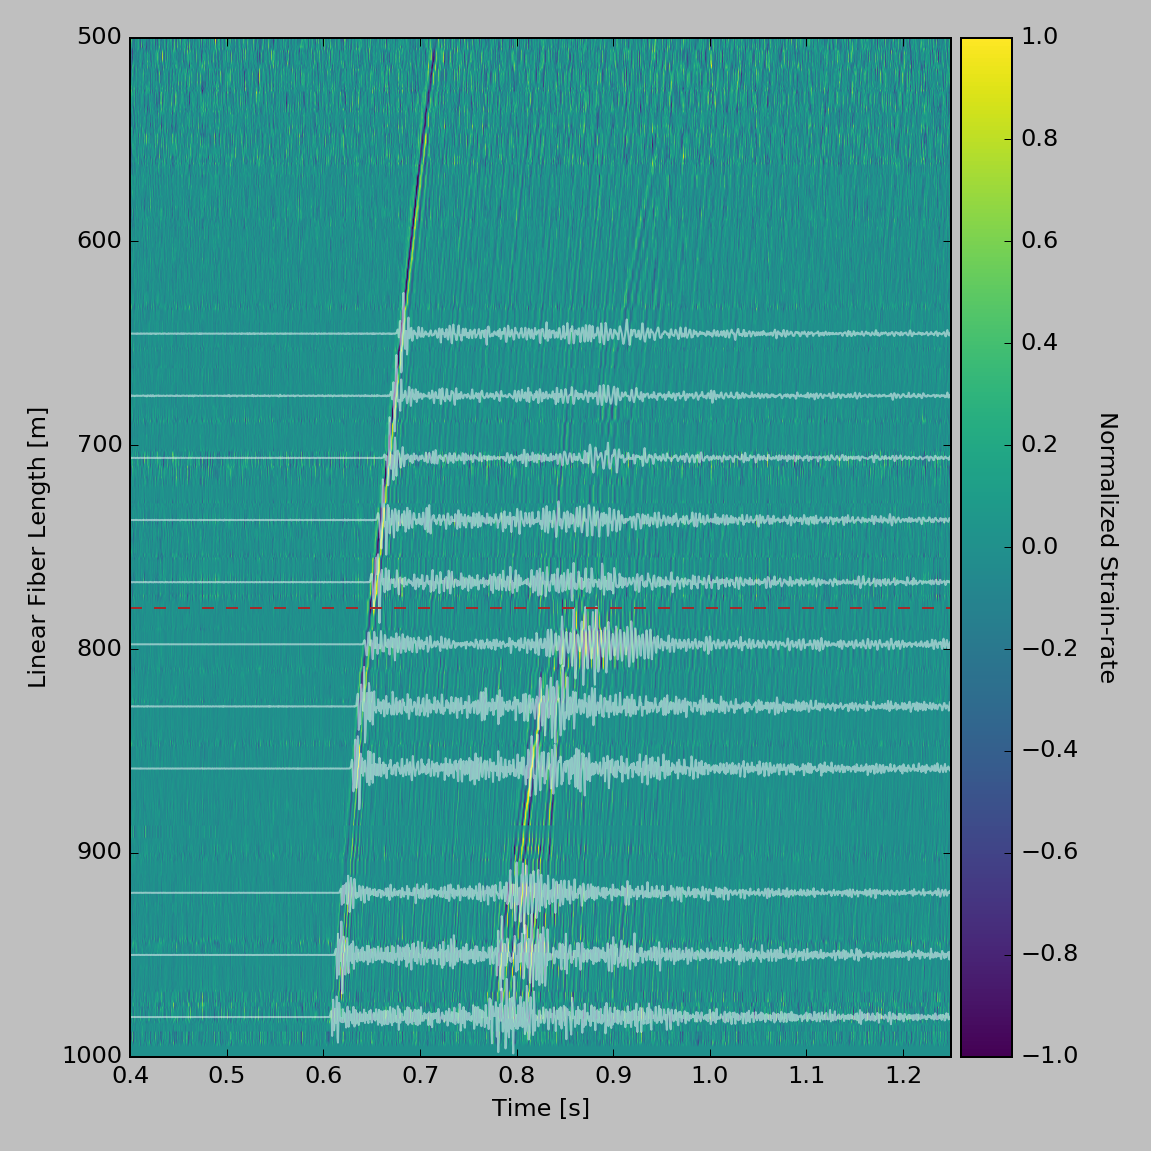

In [16]:
# plot 'D_gather_strainrate_withGvelocity_preprocessing.png
fig,ax = plotGather(das_strainrate_preprocess,padBefore,padAfter,das_distances,trnorm=1,vmin=-1,vmax=1)
sta=[0,1,2,3,4,5,6,7,9,10,11]
cha='Z'
sft = 0.44 # event1
# sft = 1.022 # event2
fig = plotGeophonesAsGather(geophone_acceleration_preprocess,padBefore,stations_to_plot=sta,
                            rescale=20,shift=sft,fig=fig,color='w')
plt.axhline(0,color='k',linestyle='-')
plt.axhline(780,color='brown',linestyle='--')
plt.xlim([0.4,1.25]) # event1
# plt.xlim([-.4,0.6])
plt.ylim([1000,500])
plt.tight_layout()
plt.savefig(figDir+'preprocessing/'+'D_gather_strainrate_withGvelocity.png',dpi=300)

In [17]:
pos = [x for x in [837,866,896,926,956,986,1016,1046,1076,1105,1136,1165]]
pos_plusHalf = [x for x in [852,881,911,941,971,1001,1031,1061,1091,1120,1151]]

In [18]:
def plotAmpSpectra(trace,normTrace=1,fig=fig,color='k',alpha=1,label=''):
    from scipy import signal
    import matplotlib.pyplot as plt
    import numpy as np
    f_psd, psd_trace = signal.welch(trace.data,fs=trace.stats.sampling_rate)
    _,psd_trace_norm = signal.welch(normTrace.data,fs=normTrace.stats.sampling_rate)
    psd_trace_norm_max = np.max(np.max(psd_trace_norm))
    plt.plot(f_psd,10*np.log10((psd_trace/psd_trace_norm_max)**2),color=color,alpha=alpha,label=label)
    return fig

NameError: name 'geophone_acceleration' is not defined

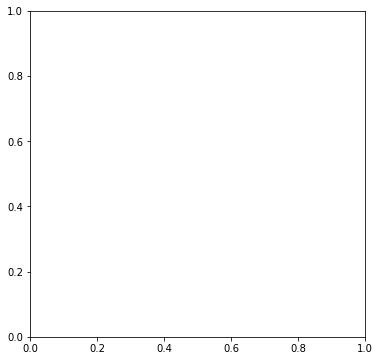

In [96]:

for geophoneIndex in range(1):
    
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    
    #EVENT 1
# #     noise_t0 = 5.3 #P only
# #     noise_t1 = 5.5
# #     signal_t0 = 5.6
# #     signal_t1 = 5.8
    noise_t0 = 3.5 #full Signal
    noise_t1 = 5
    signal_t0 = 5.5
    signal_t1 = 7
    
#     #EVENT 2
#     noise_t0 = 4.3 #S only
#     noise_t1 = 4.5
#     signal_t0 = 5.2
#     signal_t1 = 5.4
#     noise_t0 = 3.5  #full Signal
#     noise_t1 = 4.5 
#     signal_t0 = 4.75 
#     signal_t1 = 5.75 

    tr0 = geophone_acceleration[geophoneIndex].copy().normalize()
    tr0_noise = tr0.copy().trim(starttime=tr0.stats.starttime+noise_t0-sft,endtime=tr0.stats.starttime+noise_t1-sft)
    tr0_signal = tr0.copy().trim(starttime=tr0.stats.starttime+signal_t0-sft,endtime=tr0.stats.starttime+signal_t1-sft)
    fig = plotAmpSpectra(tr0_noise,normTrace=tr0_signal,fig=fig,alpha=0.5,label='Geophone Noise')
    fig = plotAmpSpectra(tr0_signal,normTrace=tr0_signal,fig=fig,label='Geophone Signal')

    # fig,ax = plt.subplots(1,1,figsize=(8,8))
    tr1 = das_strainrate_preprocess[pos_plusHalf[geophoneIndex]].copy().normalize()
    tr1_noise = tr1.copy().trim(starttime=tr1.stats.starttime+noise_t0,endtime=tr1.stats.starttime+noise_t1)
    tr1_signal = tr1.copy().trim(starttime=tr1.stats.starttime+signal_t0,endtime=tr1.stats.starttime+signal_t1)
    fig = plotAmpSpectra(tr1_noise,normTrace=tr1_signal,fig=fig,color='r',alpha=0.5,label='DAS Noise')
    fig = plotAmpSpectra(tr1_signal,normTrace=tr1_signal,fig=fig,color='r',label='DAS Signal')

#     gl=15
#     tr1s = stackLinear(das_strainrate_preprocess[int(pos_plusHalf[geophoneIndex]-gl/2):int(pos_plusHalf[geophoneIndex]+gl/2)].copy().normalize())
#     tr1s_noise = tr1s.copy().trim(starttime=tr1s.stats.starttime+noise_t0,endtime=tr1s.stats.starttime+noise_t1)
#     tr1s_signal = tr1s.copy().trim(starttime=tr1s.stats.starttime+signal_t0,endtime=tr1s.stats.starttime+signal_t1)
#     fig = plotAmpSpectra(tr1s_noise,normTrace=tr1s_signal,fig=fig,color='m',alpha=0.5,label='DAS Noise +/- '+str(gl/2))
#     fig = plotAmpSpectra(tr1s_signal,normTrace=tr1s_signal,fig=fig,color='m',label='DAS Signal +/- '+str(gl/2))

    plt.ylim(-120,30)
    plt.grid(which='both')
    plt.ylabel('Amplitude Power Spectra [dB]')
    plt.xlabel('Frequency [Hz]')
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig(figDir+'snr/psd_'+str(geophoneIndex)+'.png')
    
    
    fig,ax = plt.subplots(1,1,figsize=(10,6))
    highcut = 200
    tr0.filter('lowpass',freq=highcut)
    tr0_noise = tr0.copy().trim(starttime=tr0.stats.starttime+noise_t0-sft,endtime=tr0.stats.starttime+noise_t1-sft)
    tr0_signal = tr0.copy().trim(starttime=tr0.stats.starttime+signal_t0-sft,endtime=tr0.stats.starttime+signal_t1-sft)
    fig = plt.plot(tr0.times()+sft,tr0.data,color='gray',alpha=0.5)
    fig = plt.plot(tr0_noise.times()+noise_t0,tr0_noise.data,color='k',alpha=0.3,label='Geophone Noise')
    fig = plt.plot(tr0_signal.times()+signal_t0,tr0_signal.data,color='k',label='Geophone Signal')

    tr1.filter('lowpass',freq=highcut)
    tr1_noise = tr1.copy().trim(starttime=tr1.stats.starttime+noise_t0,endtime=tr1.stats.starttime+noise_t1)
    tr1_signal = tr1.copy().trim(starttime=tr1.stats.starttime+signal_t0,endtime=tr1.stats.starttime+signal_t1)
    fig = plt.plot(tr1.times(),tr1.data+1,color='gray',alpha=0.5)
    fig = plt.plot(tr1_noise.times()+noise_t0,tr1_noise.data+1,color='r',alpha=0.3,label='DAS Noise')
    fig = plt.plot(tr1_signal.times()+signal_t0,tr1_signal.data+1,color='r',label='DAS Signal')

#     tr1s_ = das_strainrate_preprocess[int(pos_plusHalf[geophoneIndex]-gl/2):int(pos_plusHalf[geophoneIndex]+gl/2)].copy()
#     tr1s_.filter('lowpass',freq=highcut)
#     tr1s = stackLinear(tr1s_.normalize())
#     tr1s.filter('lowpass',freq=highcut)
#     tr1s_noise = tr1s.copy().trim(starttime=tr1s.stats.starttime+noise_t0,endtime=tr1s.stats.starttime+noise_t1)
#     tr1s_signal = tr1s.copy().trim(starttime=tr1s.stats.starttime+signal_t0,endtime=tr1s.stats.starttime+signal_t1)
#     fig = plt.plot(tr1s.times(),tr1s.data+2,color='gray',alpha=0.5)
#     fig = plt.plot(tr1s_noise.times()+noise_t0,tr1s_noise.data+2,color='m',alpha=0.3,label='DAS Noise +/- '+str(gl/2))
#     fig = plt.plot(tr1s_signal.times()+signal_t0,tr1s_signal.data+2,color='m',label='DAS Signal +/- '+str(gl/2))

#     plt.xlim([.2,.5]) # event1
#     plt.xlim([3,7]) # event2, full signal
    plt.xlim([4.,6]) # event2, s-wave only

#     plt.grid(which='both')
    plt.ylabel('')
    plt.xlabel('Time [s]')
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig(figDir+'snr/timeseries_'+str(geophoneIndex)+'.png')

In [ ]:


#


def plotFK(f,k,fk,vmin=-3,vmax=5):
    import numpy as np
    import matplotlib.pyplot as plt
    fig,ax = plt.subplots(figsize=(5,5))
    plt.imshow(np.log10(np.abs(fk)),extent=[min(f),max(f),min(k),max(k)],
               aspect='auto',cmap='jet',vmin=vmin,vmax=vmax)
    h = plt.colorbar()
    h.set_label('Power [strain-rate]')
    plt.xlabel('frequency [1/s]')
    plt.ylabel('wavenumber [1/m]')
    c=3000; ax.plot(f,f/c,color='r'); ax.plot(-f,f/c,color='r')
#     c=45; ax.plot(f,f/c,color='r'); ax.plot(-f,f/c,color='r')
    plt.tight_layout()
    return ax

#
dx = 1.08
ot = 0.
nametag = figDir+'event1_das'
das_norm = False
#
das = strainrate_from_das_pp.copy()
das.normalize(global_max = False)
for i,tr in enumerate(das):
    tr.stats.distance = dx*i
start = das[0].stats.starttime+30.
end = das[0].stats.starttime+31
#
distances2 = [tr.stats.distance for tr in strainrate_from_das]
ntr = len(das)
das.normalize(global_max=False)
nametag = nametag+'_trNorm'



# #
# fig,ax = plotSpectra(das,distances2,)
# plt.tight_layout()
# plt.savefig(nametag+'_psd.png',dpi=300)

# #
# F,K,SPEC = fk(das,dx)
# ax = plotFK(F,K,SPEC,vmin=2,vmax=3.5)
# plt.xlim([-1000,1000])
# plt.ylim([-0.5,0.5])

##### Convert geophone velocity data to strainrate_from_geophone data

In [8]:
#
# Geophones.Z create raw stream for ploting
#
# dU/dt = iwU
# d(dU/dt)/dt = -w^2U
# d(dU/dx)/dt = d(dU/dt)/dx = (dU2/dt - dU1/dt) / (X2-X1) = ik(U2-U1)
#

# half_distances=[d+30.48/2 for d in distances[:-1]]
# intervals = [distances[x+1] - distances[x] for x in range(len(distances)-1)]
# strainrate_from_geophone = velocity_from_geophone.select(channel='Z').copy()[:-1]
# for i,tr in enumerate(strainrate_from_geophone):
#     tr.data = (velocity_from_geophone.select(channel='Z')[i+1].data - velocity_from_geophone.select(channel='Z')[i].data) / intervals[i];
#     tr.stats.distance = half_distances[i];

# #
# fig = plt.figure(figsize=(10,3))
# strainrate_from_geophone[0].plot(fig=fig,show=False);
# velocity_from_geophone.select(channel='Z')[0].plot(fig=fig)

# Preprocess geophone and DAS data

In [389]:


strainrate_from_das_pp = preprocessing_for_das(strainrate_from_das,dx,fmin,fmax)
acc_from_geophone_pp = preprocessing_for_geophones(velocity_from_geophone,fmin,fmax)

In [404]:
fmin=1
fmax=999
dx = 1.08

In [350]:
tr0.data

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

# Plot Gathers

##### Geophone velocity only

In [464]:
figDir

'../figs/preprocessing/'

/Users/nate/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


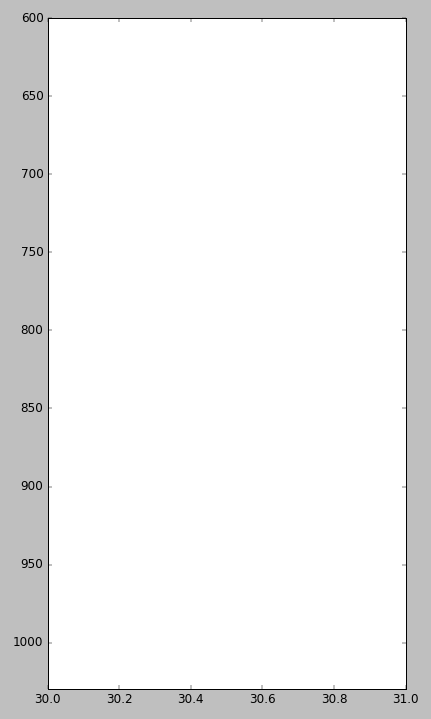

In [465]:
fig,ax = plt.subplots(1,1,figsize=(6,10))

# #
geo_shift=0
fmin=50
fmax=1000
gph_skip  = 1
gph_scale = 40.
gph_color = 'r'
gph_color2 = 'm'
gph_norm  = True
# gph_kill = [8]
gph = velocity_from_geophone_pp.copy()
for i,tr in enumerate(gph):
    if i==0:
        plt.plot(geo_shift+tr.times(),gph_scale*tr.data+(tr.stats.distance),color=gph_color,alpha=1,label='Geophone.2')
    else:
        plt.plot(geo_shift+tr.times(),gph_scale*tr.data+(tr.stats.distance),color=gph_color,alpha=1)
plt.ylim([1030,600])
plt.xlim([30,31])
plt.tight_layout()
plt.savefig(figDir+'geophonesAcc.png')

/Users/nate/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


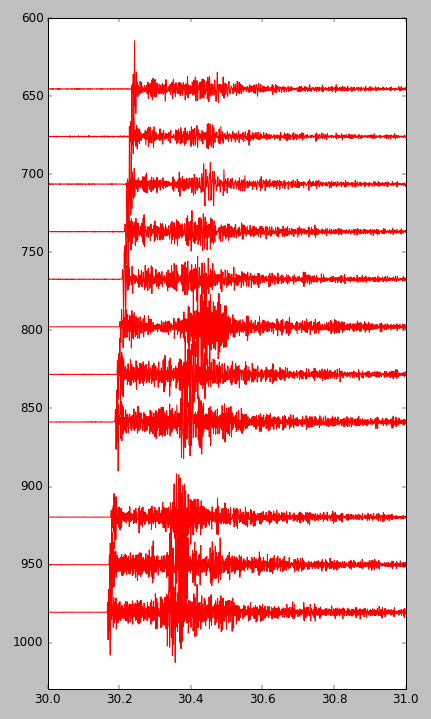

In [463]:
fig,ax = plt.subplots(1,1,figsize=(6,10))

# #
geo_shift=0
fmin=50
fmax=1000
gph_skip  = 1
gph_scale = 40.
gph_color = 'r'
gph_color2 = 'm'
gph_norm  = True
# gph_kill = [8]
gph = acc_from_geophone_pp.copy()
for i,tr in enumerate(gph):
    if i==0:
        plt.plot(geo_shift+tr.times(),gph_scale*tr.data+(tr.stats.distance),color=gph_color,alpha=1,label='Geophone.2')
    else:
        plt.plot(geo_shift+tr.times(),gph_scale*tr.data+(tr.stats.distance),color=gph_color,alpha=1)
plt.ylim([1030,600])
plt.xlim([30,31])
plt.tight_layout()
plt.savefig(figDir+'geophonesAcc.png')

##### Geophone strain-rate only

<IPython.core.display.Javascript object>


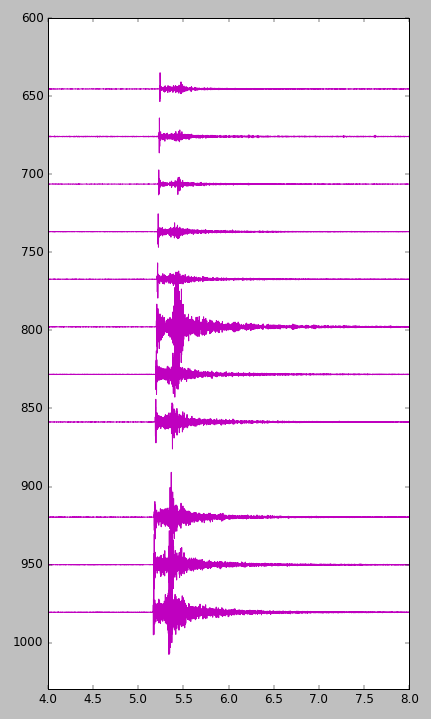

/Users/nate/opt/miniconda3/lib/python3.7/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (1000) of bandpass is at or above Nyquist (1000.0). Applying a high-pass instead.
  warnings.warn(msg)


In [21]:
fig,ax = plt.subplots(1,1,figsize=(6,10))

# #
geo_shift=0
fmin=50
fmax=1000
gph_skip  = 1
gph_scale = 40.
gph_color = 'm'
gph_color2 = 'm'
gph_norm  = True
gph_kill = [8]
gph = G.select(channel='Z').copy()
gph.filter('bandpass',freqmin=fmin,freqmax=fmax,zerophase=False,corners=4)
gph.normalize(global_max=gph_norm)
for tr in gph_kill:
    gph[tr].data*=np.nan
for i,tr in enumerate(gph):
    if i==0:
        plt.plot(geo_shift+tr.times(),gph_scale*tr.data+(tr.stats.distance),color=gph_color,alpha=1,label='Geophone.2')
    else:
        plt.plot(geo_shift+tr.times(),gph_scale*tr.data+(tr.stats.distance),color=gph_color,alpha=1)
plt.ylim([1030,600])
plt.xlim([4,8])
plt.tight_layout()
plt.savefig(figDir+'geophones.png')

In [491]:
strainrate_from_das_pp

1280 Trace(s) in Stream:

Seq. No. in line:    1 | 2019-04-27T20:20:27.000000Z - 2019-04-27T20:21:27.000000Z | 2000.0 Hz, 120001 samples
...
(1278 other traces)
...
Seq. No. in line:    1 | 2019-04-27T20:20:27.000000Z - 2019-04-27T20:21:27.000000Z | 2000.0 Hz, 120001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

/Users/nate/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


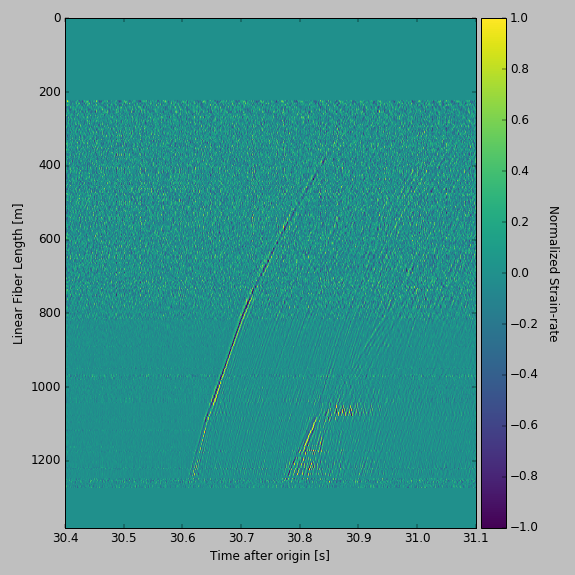

/Users/nate/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/Users/nate/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


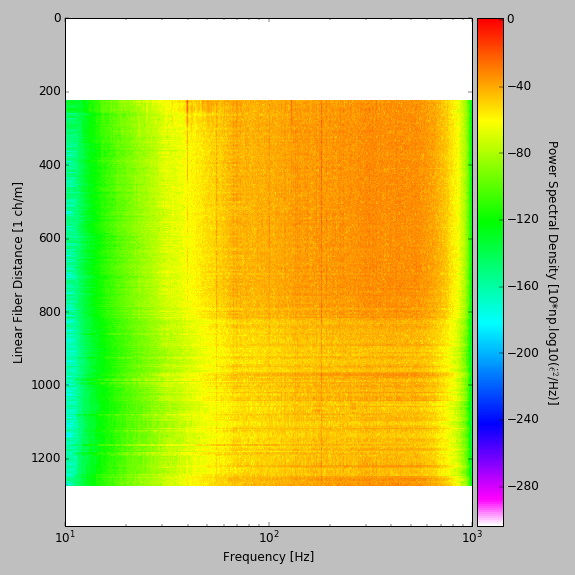

/Users/nate/.local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


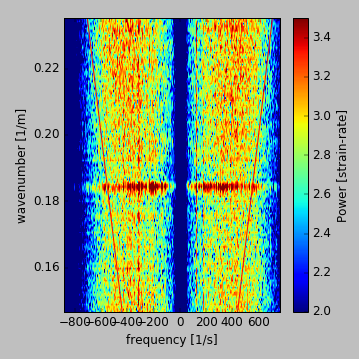

(-0.5, 0.5)